In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    auc,
    precision_score,
    f1_score,
    recall_score
)
from imblearn.under_sampling import RandomUnderSampler

In [2]:
pip install xgboost

In [3]:
df = pd.read_csv("HI-Small_Trans.csv")
df.head(10)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0
5,2022/09/01 00:03,1,8000F5AD0,1,8000F5AD0,6162.44,US Dollar,6162.44,US Dollar,Reinvestment,0
6,2022/09/01 00:08,1,8000EBAC0,1,8000EBAC0,14.26,US Dollar,14.26,US Dollar,Reinvestment,0
7,2022/09/01 00:16,1,8000EC1E0,1,8000EC1E0,11.86,US Dollar,11.86,US Dollar,Reinvestment,0
8,2022/09/01 00:26,12,8000EC280,2439,8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0
9,2022/09/01 00:21,1,8000EDEC0,211050,80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [5]:
df.isna().sum()

,0
Timestamp,0
From Bank,0
Account,0
To Bank,0
Account.1,0
Amount Received,0
Receiving Currency,0
Amount Paid,0
Payment Currency,0
Payment Format,0


In [6]:
object_cols = df.select_dtypes('object').columns.drop('Timestamp')
df[object_cols] = df[object_cols].astype('string')

In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             string        
 3   To Bank             int64         
 4   Account.1           string        
 5   Amount Received     float64       
 6   Receiving Currency  string        
 7   Amount Paid         float64       
 8   Payment Currency    string        
 9   Payment Format      string        
 10  Is Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), string(5)
memory usage: 426.2 MB


In [9]:
df.duplicated().sum()

np.int64(9)

In [10]:
len(df)

5078345

In [11]:
df.drop_duplicates()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022-09-10 23:57:00,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022-09-10 23:35:00,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022-09-10 23:52:00,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022-09-10 23:46:00,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [12]:
df['Same Account'] = df['Account']==df['Account.1']

In [13]:
df['Same Bank'] = df['From Bank']==df['To Bank']

In [14]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Same Account,Same Bank
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,True,True
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,False,False
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,True,True
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,True,True
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,True,True


In [15]:
df = df.drop(['Account','Account.1'],axis=1)
df.head()

,Timestamp,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Same Account,Same Bank
0,2022-09-01 00:20:00,10,10,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,True,True
1,2022-09-01 00:20:00,3208,1,0.01,US Dollar,0.01,US Dollar,Cheque,0,False,False
2,2022-09-01 00:00:00,3209,3209,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,True,True
3,2022-09-01 00:02:00,12,12,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,True,True
4,2022-09-01 00:06:00,10,10,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,True,True


In [16]:
df['Is Laundering'].value_counts()

,count
Is Laundering,
0,5073168
1,5177


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['string','bool']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
df.head()

,Timestamp,From Bank,To Bank,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Same Account,Same Bank
0,2022-09-01 00:20:00,10,10,3697.34,12,3697.34,12,5,0,1,1
1,2022-09-01 00:20:00,3208,1,0.01,12,0.01,12,3,0,0,0
2,2022-09-01 00:00:00,3209,3209,14675.57,12,14675.57,12,5,0,1,1
3,2022-09-01 00:02:00,12,12,2806.97,12,2806.97,12,5,0,1,1
4,2022-09-01 00:06:00,10,10,36682.97,12,36682.97,12,5,0,1,1


In [18]:
X = df.drop(['Is Laundering','Timestamp'],axis=1)
y = df['Is Laundering']

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    auc,
    precision_score,
    f1_score,
    recall_score
)
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

Experiment 1 - Without undersampling

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

Logistic Regression

In [21]:
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# pipeline_lr = Pipeline([
#     ('scaler', StandardScaler()),
#     ('clf',    LogisticRegression(max_iter=10000, random_state=42))
# ])

# param_grid_lr = {
#     'clf__C':          [0.01, 0.1, 1, 10, 100],
#     'clf__penalty':    ['l1', 'l2', 'elasticnet'],
#     'clf__solver':     ['saga'],
#     'clf__l1_ratio':   [0.0, 0.5, 1.0],
#     'clf__class_weight':[None, 'balanced']
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_lr = GridSearchCV(
#     pipeline_lr,
#     param_grid=param_grid_lr,
#     scoring='f1',
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )

# grid_lr.fit(X_train, y_train)

# print("Best params:", grid_lr.best_params_)
# print("Best CV F1: ", grid_lr.best_score_)


In [22]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pipeline_best_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(
        C=100,
        penalty='l2',
        solver='saga',
        l1_ratio=0.0,
        class_weight=None,
        max_iter=10000,
        random_state=42
    ))
])

pipeline_best_lr.fit(X_train, y_train)

y_proba_test = pipeline_best_lr.predict_proba(X_test)[:, 1]
y_pred_test  = pipeline_best_lr.predict(X_test)

roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report ( Experiment 1 (Logistic Regression)):")
print(classification_report(y_test, y_pred_test, zero_division=0))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Test ROC-AUC: 0.9043

Classification Report ( Experiment 1 (Logistic Regression)):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521951
           1       0.00      0.00      0.00      1553

    accuracy                           1.00   1523504
   macro avg       0.50      0.50      0.50   1523504
weighted avg       1.00      1.00      1.00   1523504



XGBoost

In [23]:
# from imblearn.pipeline import Pipeline
# from imblearn.under_sampling import RandomUnderSampler
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# pipeline_xgb = Pipeline([
#     ('clf', XGBClassifier(
#         use_label_encoder=False,
#         eval_metric='logloss',
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# param_grid_xgb = {
#     'clf__n_estimators':    [100, 200, 300],
#     'clf__max_depth':       [3, 6, 10],
#     'clf__learning_rate':   [0.01, 0.1, 0.2],
#     'clf__subsample':       [0.6, 0.8, 1.0],
#     'clf__colsample_bytree':[0.6, 0.8, 1.0],
#     'clf__gamma':           [0, 1, 5]
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_xgb = GridSearchCV(
#     pipeline_xgb,
#     param_grid=param_grid_xgb,
#     scoring='f1',
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )

# grid_xgb.fit(X_train, y_train)

# print("Best params (Experiment 1):", grid_xgb.best_params_)
# print("Best CV F1 (Experiment 1): ", grid_xgb.best_score_)


In [24]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

pipeline_best_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    XGBClassifier(
        colsample_bytree = 1.0,
        gamma = 0,
        learning_rate = 0.1,
        max_depth = 10,
        n_estimators = 300,
        subsample = 0.8
        ))
])

pipeline_best_xgb.fit(X_train, y_train)

y_proba_test = pipeline_best_xgb.predict_proba(X_test)[:, 1]
y_pred_test  = pipeline_best_xgb.predict(X_test)

roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report (Experiment 1: XGBoost):")
print(classification_report(y_test, y_pred_test, zero_division=0))

Test ROC-AUC: 0.9671

Classification Report (Experiment 1: XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521951
           1       0.79      0.10      0.18      1553

    accuracy                           1.00   1523504
   macro avg       0.89      0.55      0.59   1523504
weighted avg       1.00      1.00      1.00   1523504



Experiment 2 - With undersampling and SMOTE

In [25]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

pipe = Pipeline([('rus', RandomUnderSampler(sampling_strategy=0.2,random_state=42)),
                ('smote',SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42))])
X_train_res, y_train_res = pipe.fit_resample(X_train, y_train)

print("Resampled training size:", X_train_res.shape)
print("Test set size (unchanged):", X_test.shape)

Resampled training size: (31065, 9)
Test set size (unchanged): (1015669, 9)


In [26]:
X_test_res, y_test_res = pipe.fit_resample(X_test, y_test)
print("Resampled Test set size:", X_test_res.shape)

Resampled Test set size: (7762, 9)


In [27]:
print("Resampled test set size:", y_test_res.shape)

Resampled test set size: (7762,)


In [28]:
count = 0
for x in y_train_res:
    if x==1:
        count+=1
print(count)

10355


Logistic Regression

In [29]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(max_iter=10000, random_state=42))
])

param_grid_lr = {
    'clf__C':          [0.01, 0.1, 1, 10, 100],
    'clf__penalty':    ['l1', 'l2', 'elasticnet'],
    'clf__solver':     ['saga'],
    'clf__l1_ratio':   [0.0, 0.5, 1.0],
    'clf__class_weight':[None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 Logistic Regression):", grid_lr.best_params_)
print("Best CV F1 (Experiment 2 Logistic Regression): ", grid_lr.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best params (Experiment 2 Logistic Regression): {'clf__C': 0.1, 'clf__class_weight': None, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'}
Best CV F1 (Experiment 2 Logistic Regression):  0.8329738974023776


In [30]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pipeline_best_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(
        C=100,
        penalty='l1',
        solver='saga',
        l1_ratio=0.0,
        class_weight=None,
        max_iter=10000,
        random_state=42
    ))
])

pipeline_best_lr.fit(X_train_res, y_train_res)

y_proba_test = pipeline_best_lr.predict_proba(X_test_res)[:, 1]
y_pred_test  = pipeline_best_lr.predict(X_test_res)

roc_auc = roc_auc_score(y_test_res, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report (Experiment 2 Logistic Regression):")
print(classification_report(y_test_res, y_pred_test, zero_division=0))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Test ROC-AUC: 0.9218

Classification Report (Experiment 2 Logistic Regression):
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5175
           1       0.80      0.89      0.84      2587

    accuracy                           0.89      7762
   macro avg       0.87      0.89      0.88      7762
weighted avg       0.89      0.89      0.89      7762



Random Forest

# 60 combos

In [31]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_rf = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators':       [100, 200, 300],
    'clf__max_depth':          [10],
    'clf__min_samples_split':  [2, 5],
    'clf__min_samples_leaf':   [1, 2],
    'clf__max_features':       ['sqrt'],
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid_rf.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 Random Forest):", grid_rf.best_params_)
print("Best CV F1 (Experiment 2 Random Forest): ", grid_rf.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.4s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.2s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.0s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_

# 180 combos

In [32]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_rf = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators':       [100, 200, 300],
    'clf__max_depth':          [10,20],
    'clf__min_samples_split':  [2, 5, 10],
    'clf__min_samples_leaf':   [1, 2],
    'clf__max_features':       ['sqrt'],
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid_rf.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 Random Forest):", grid_rf.best_params_)
print("Best CV F1 (Experiment 2 Random Forest): ", grid_rf.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.3s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.3s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   3.6s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples

# 360 Combos

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_rf = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators':       [100, 200, 300],
    'clf__max_depth':          [10,20],
    'clf__min_samples_split':  [2, 5, 10],
    'clf__min_samples_leaf':   [1, 2],
    'clf__max_features':       ['sqrt','log2'],
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid_rf.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 Random Forest):", grid_rf.best_params_)
print("Best CV F1 (Experiment 2 Random Forest): ", grid_rf.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.4s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.8s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.0s
[CV] END clf__max_depth=10, clf__max_features=sqrt, clf__min_samples

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

pipeline_best_rf = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_best_rf.fit(X_train_res, y_train_res)

y_proba_test = pipeline_best_rf.predict_proba(X_test_res)[:, 1]
y_pred_test  = pipeline_best_rf.predict(X_test_res)

roc_auc = roc_auc_score(y_test_res, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report (Experiment 2 Random Forest):")
print(classification_report(y_test_res, y_pred_test, zero_division=0))


Test ROC-AUC: 0.9701

Classification Report (Experiment 2 Random Forest):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5175
           1       0.82      0.93      0.87      2587

    accuracy                           0.91      7762
   macro avg       0.89      0.91      0.90      7762
weighted avg       0.92      0.91      0.91      7762



XGBoost

In [35]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_xgb = Pipeline([
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

param_grid_xgb = {
    'clf__n_estimators':    [100, 200, 300],
    'clf__max_depth':       [3, 6, 10],
    'clf__learning_rate':   [0.01, 0.1, 0.2],
    'clf__subsample':       [0.6, 0.8, 1.0],
    'clf__colsample_bytree':[0.6, 0.8, 1.0],
    'clf__gamma':           [0, 1, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 XGBoost):", grid_xgb.best_params_)
print("Best CV F1 (Experiment 2 XGBoost): ", grid_xgb.best_score_)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:01:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params (Experiment 2 XGBoost): {'clf__colsample_bytree': 0.6, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Best CV F1 (Experiment 2 XGBoost):  0.896130308628248


XGBOOST - Best params (Experiment 2 XGBoost): {'clf__colsample_bytree': 0.6, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Best CV F1 (Experiment 2 XGBoost):  0.8961000167177406

In [36]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pipeline_best_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    XGBClassifier(
        colsample_bytree = 0.6,
        gamma = 0,
        learning_rate = 0.1,
        max_depth = 10,
        n_estimators = 100,
        subsample = 1.0
        ))
])

pipeline_best_xgb.fit(X_train_res, y_train_res)

y_proba_test = pipeline_best_xgb.predict_proba(X_test_res)[:, 1]
y_pred_test  = pipeline_best_xgb.predict(X_test_res)

roc_auc = roc_auc_score(y_test_res, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report (Experiment 2 XGBoost):")
print(classification_report(y_test_res, y_pred_test, zero_division=0))

Test ROC-AUC: 0.9778

Classification Report (Experiment 2 XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5175
           1       0.88      0.89      0.89      2587

    accuracy                           0.92      7762
   macro avg       0.91      0.91      0.91      7762
weighted avg       0.92      0.92      0.92      7762



AdaBoost

In [37]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline_ada = Pipeline([
    ('clf', AdaBoostClassifier(random_state=42))
])

param_grid_ada = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ada = GridSearchCV(
    pipeline_ada,
    param_grid=param_grid_ada,
    scoring='precision',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_ada.fit(X_train_res, y_train_res)

print("Best params (Experiment 2 AdaBoost):", grid_ada.best_params_)
print("Best CV precision (Experiment 2 AdaBoost): ", grid_ada.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params (Experiment 2 AdaBoost): {'clf__learning_rate': 1.0, 'clf__n_estimators': 100}
Best CV precision (Experiment 2 AdaBoost):  0.8019223011206413


In [38]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier

pipeline_ada_best = Pipeline([
    ('clf', AdaBoostClassifier(
        n_estimators=200,
        learning_rate=1.0,
        random_state=42
    ))
])

pipeline_ada_best.fit(X_train_res, y_train_res)

y_pred = pipeline_ada_best.predict(X_test_res)

y_proba_test = pipeline_ada_best.predict_proba(X_test_res)[:, 1]
y_pred_test  = pipeline_ada_best.predict(X_test_res)

roc_auc = roc_auc_score(y_test_res, y_proba_test)
print(f"Test ROC-AUC: {roc_auc:.4f}\n")

print("Classification Report (Experiment 2 AdaBoost):")
print(classification_report(y_test_res, y_pred_test, zero_division=0))

Test ROC-AUC: 0.9579

Classification Report (Experiment 2 AdaBoost):
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5175
           1       0.80      0.90      0.84      2587

    accuracy                           0.89      7762
   macro avg       0.87      0.89      0.88      7762
weighted avg       0.90      0.89      0.89      7762



ROC-AUC on Test Set: 0.9559326547266246

Classification Report (Threshold = 0.5):
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      5175
           1       0.80      0.89      0.84      2587

    accuracy                           0.89      7762
   macro avg       0.87      0.89      0.88      7762
weighted avg       0.89      0.89      0.89      7762



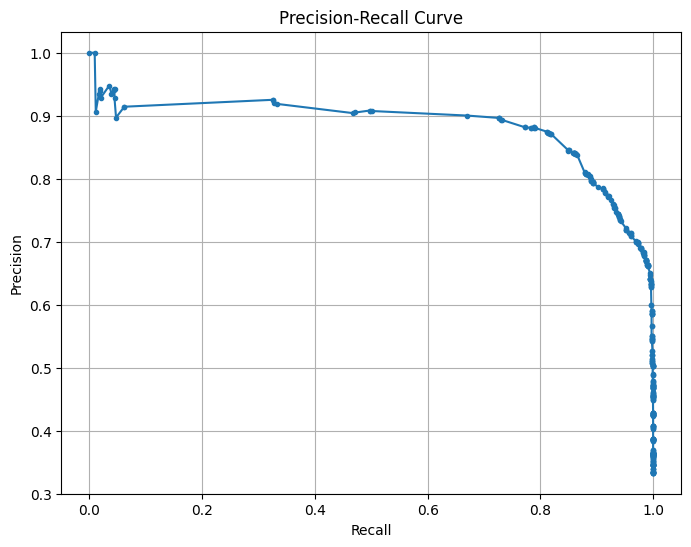


Classification Report (Threshold = 0.7):
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      5175
           1       0.00      0.00      0.00      2587

    accuracy                           0.67      7762
   macro avg       0.33      0.50      0.40      7762
weighted avg       0.44      0.67      0.53      7762



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

best_ada_model = grid_ada.best_estimator_
best_ada_model.fit(X_train_res, y_train_res)

y_probs = best_ada_model.predict_proba(X_test_res)[:, 1]

y_pred_default = (y_probs >= 0.5).astype(int)

print("ROC-AUC on Test Set:", roc_auc_score(y_test_res, y_probs))
print("\nClassification Report (Threshold = 0.5):\n", classification_report(y_test_res, y_pred_default))

precision, recall, thresholds = precision_recall_curve(y_test_res, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

custom_threshold = 0.7
y_pred_custom = (y_probs >= custom_threshold).astype(int)

print(f"\nClassification Report (Threshold = {custom_threshold}):\n", classification_report(y_test_res, y_pred_custom))


DEEP NN and MLP

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

print("Train shapes:", X_train_res.shape, y_train_res.shape)
print("Test shapes:",  X_test_res.shape,  y_test_res.shape)
print("NaNs in X_train_res:", np.isnan(X_train_res).any())
print("NaNs in X_test_res:",  np.isnan(X_test_res).any())

def build_mlp(input_dim):
    """Shallow MLP: two hidden layers with moderate dropout"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model


def build_deep_nn(input_dim):
    """Deeper NN: three hidden layers with reduced dropout and higher learning rate"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-2),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model



Train shapes: (31065, 9) (31065,)
Test shapes: (7762, 9) (7762,)
NaNs in X_train_res: From Bank             False
To Bank               False
Amount Received       False
Receiving Currency    False
Amount Paid           False
Payment Currency      False
Payment Format        False
Same Account          False
Same Bank             False
dtype: bool
NaNs in X_test_res: From Bank             False
To Bank               False
Amount Received       False
Receiving Currency    False
Amount Paid           False
Payment Currency      False
Payment Format        False
Same Account          False
Same Bank             False
dtype: bool


In [41]:
input_dim = X_train_res.shape[1]
mlp_model     = build_mlp(input_dim)
deep_model    = build_deep_nn(input_dim)

# es = callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)


history_mlp = mlp_model.fit(
    X_train_res, y_train_res,
    validation_split=0.1,
    epochs=50,
    batch_size=256,
    verbose=2
)

history_deep = deep_model.fit(
    X_train_res, y_train_res,
    validation_split=0.1,
    epochs=50,
    batch_size=256,
    verbose=2
)

Epoch 1/50
110/110 - 4s - 33ms/step - auc: 0.5348 - loss: 0.6809 - val_auc: 0.0000e+00 - val_loss: 1.0061
Epoch 2/50
110/110 - 2s - 16ms/step - auc: 0.5681 - loss: 0.5930 - val_auc: 0.0000e+00 - val_loss: 1.1758
Epoch 3/50
110/110 - 1s - 5ms/step - auc: 0.6002 - loss: 0.5730 - val_auc: 0.0000e+00 - val_loss: 1.1420
Epoch 4/50
110/110 - 1s - 9ms/step - auc: 0.6166 - loss: 0.5627 - val_auc: 0.0000e+00 - val_loss: 1.1554
Epoch 5/50
110/110 - 1s - 12ms/step - auc: 0.6317 - loss: 0.5573 - val_auc: 0.0000e+00 - val_loss: 1.2501
Epoch 6/50
110/110 - 1s - 5ms/step - auc: 0.6382 - loss: 0.5537 - val_auc: 0.0000e+00 - val_loss: 1.2380
Epoch 7/50
110/110 - 1s - 7ms/step - auc: 0.6406 - loss: 0.5543 - val_auc: 0.0000e+00 - val_loss: 1.2230
Epoch 8/50
110/110 - 1s - 6ms/step - auc: 0.6441 - loss: 0.5496 - val_auc: 0.0000e+00 - val_loss: 1.3113
Epoch 9/50
110/110 - 1s - 11ms/step - auc: 0.6501 - loss: 0.5471 - val_auc: 0.0000e+00 - val_loss: 1.2620
Epoch 10/50
110/110 - 1s - 9ms/step - auc: 0.6598 -

In [42]:
mlp_loss, mlp_auc = mlp_model.evaluate(X_test_res, y_test_res, verbose=0)
deep_loss, deep_auc = deep_model.evaluate(X_test_res, y_test_res, verbose=0)
print(f"MLP Test AUC (Experiment 2): {mlp_auc:.4f}")
print(f"Deep NN Test AUC (Experiment 2): {deep_auc:.4f}\n")

MLP Test AUC (Experiment 2): 0.7485
Deep NN Test AUC (Experiment 2): 0.7425



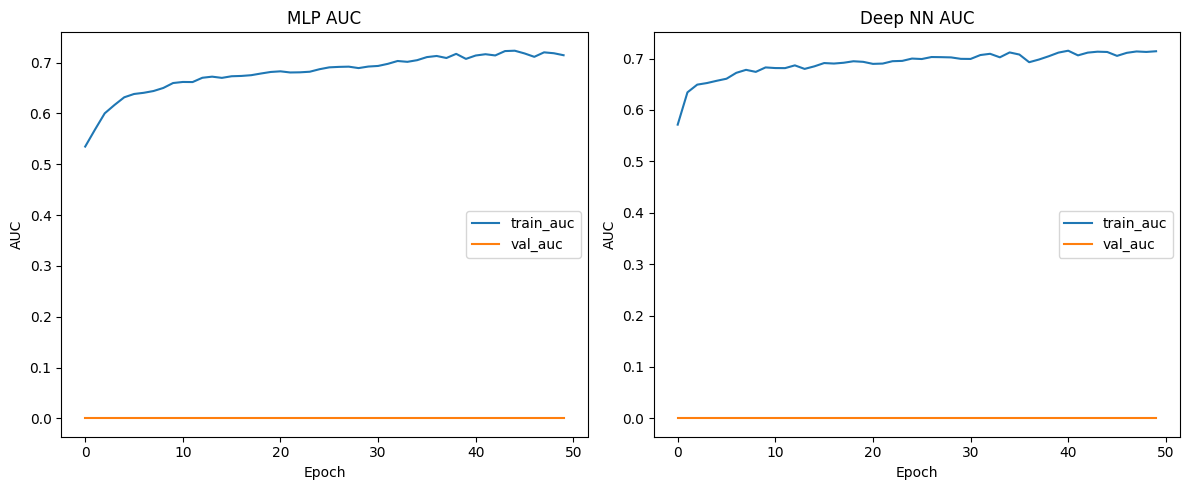

In [43]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_mlp.history['auc'], label='train_auc')
plt.plot(history_mlp.history['val_auc'], label='val_auc')
plt.title('MLP AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_deep.history['auc'], label='train_auc')
plt.plot(history_deep.history['val_auc'], label='val_auc')
plt.title('Deep NN AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
y_pred_mlp  = (mlp_model.predict(X_test_res) >= 0.5).astype(int)
print("Classification Report for MLP (Experiment 2):")
print(classification_report(y_test_res, y_pred_mlp))

y_pred_deep = (deep_model.predict(X_test_res) >= 0.5).astype(int)
print("Classification Report for Deep NN (Experiment 2):")
print(classification_report(y_test_res, y_pred_deep))

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for MLP (Experiment 2):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      5175
           1       0.00      0.00      0.00      2587

    accuracy                           0.67      7762
   macro avg       0.33      0.50      0.40      7762
weighted avg       0.44      0.67      0.53      7762

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for Deep NN (Experiment 2):
              precision    recall  f1-score   support

           0       0.68      0.98      0.80      5175
           1       0.66      0.09      0.15      2587

    accuracy                           0.68      7762
   macro avg       0.67      0.53      0.48      7762
weighted avg       0.68      0.68      0.59      7762



243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep NN PR AUC: 0.5367


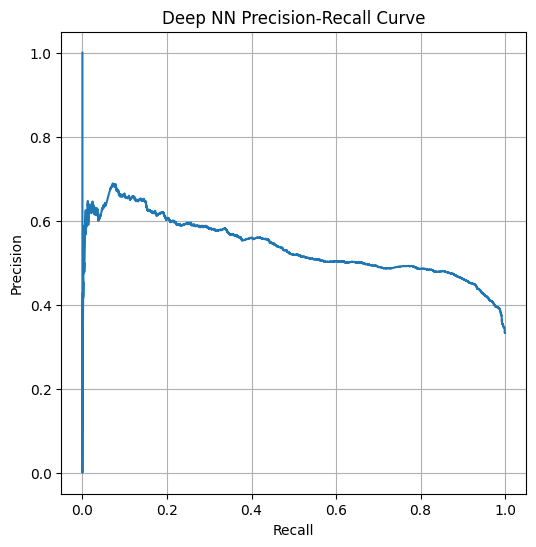

In [45]:
probs_deep = deep_model.predict(X_test_res).ravel()
precision, recall, thresholds = precision_recall_curve(y_test_res, probs_deep)
pr_auc = auc(recall, precision)
print(f"Deep NN PR AUC: {pr_auc:.4f}")

# Plot PR curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision)
plt.title('Deep NN Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

Experiment 3 - Combining multiple classifiers

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

rf    = RandomForestClassifier(n_estimators=100, random_state=42)
xgb   = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
ada   = AdaBoostClassifier(n_estimators=100, random_state=42)
gb    = GradientBoostingClassifier(n_estimators=100, random_state=42)
mlp   = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('ada', ada),
        ('gb', gb),
        ('mlp', mlp)
    ],
    voting='soft',
    n_jobs=-1
)

pipeline_ensemble = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ensemble)
])

pipeline_ensemble.fit(X_train_res, y_train_res)

y_proba_test = pipeline_ensemble.predict_proba(X_test_res)[:, 1]
y_pred_test  = pipeline_ensemble.predict(X_test_res)

from sklearn.metrics import roc_auc_score, classification_report
print("ROC-AUC:", roc_auc_score(y_test_res, y_proba_test))
print(classification_report(y_test_res, y_pred_test, zero_division=0))


ROC-AUC: 0.9744604105626609
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5175
           1       0.87      0.90      0.89      2587

    accuracy                           0.92      7762
   macro avg       0.91      0.92      0.91      7762
weighted avg       0.92      0.92      0.92      7762



Experiment 4 - Implementing Isolation forest

In [47]:
X_train_res.shape

(31065, 9)

In [48]:
X_test_res.shape

(7762, 9)

In [58]:
y_train_res.shape

(31065,)

In [50]:
y_test_res.shape

(7762,)

In [62]:
import numpy as np
from sklearn.ensemble import IsolationForest, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

class IsolationForestClassifier(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"

    def __init__(self, random_state=42, n_estimators=100, contamination='auto'):
        self.iforest = IsolationForest(random_state=random_state, n_estimators=n_estimators, contamination=contamination)

    def fit(self, X, y=None):
        self.iforest.fit(X)
        return self

    def predict(self, X):
        raw = self.iforest.predict(X)
        return np.where(raw == -1, 1, 0)

    def predict_proba(self, X):
        scores = self.iforest.decision_function(X)
        min_s, max_s = scores.min(), scores.max()
        if max_s > min_s:
            norm = (scores - min_s) / (max_s - min_s)
        else:
            norm = np.zeros_like(scores)
        return np.vstack([norm, 1 - norm]).T

rf  = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
gb  = GradientBoostingClassifier(n_estimators=100, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
iso = IsolationForestClassifier(random_state=42, n_estimators=100, contamination=0.05)

voting_clf = VotingClassifier(
    estimators=[
        ('rf',  rf),
        ('xgb', xgb),
        ('ada', ada),
        ('gb',  gb),
        ('mlp', mlp)
    ],
    voting='soft'
)

mask = iso.fit(X_train_res).predict(X_train_res) == 0
X_train_clean = X_train_res[mask]
y_train_clean = y_train_res[mask]

pipeline = Pipeline([
    ('rus',    RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('voting', voting_clf)
])

pipeline.fit(X_train_clean, y_train_clean)
y_pred = pipeline.predict(X_test_res)
print(classification_report(y_test_res, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:07:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5175
           1       0.83      0.93      0.87      2587

    accuracy                           0.91      7762
   macro avg       0.89      0.92      0.90      7762
weighted avg       0.92      0.91      0.91      7762



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [63]:
X_train_clean.shape

(29511, 9)

In [64]:
X_train_res.shape

(31065, 9)